# Modeling

In this notebook I create the final machine learning models to predict house prices. I will be trying out different feature combinations, different hyperparameter values, and I will experiment with using the log-transformed price and regular price as target values for the models.

In [179]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [180]:
# import data
df = pd.read_csv("train.csv")

#remove outliers
df = df.sort_values("log_price")[:-5]

# shuffle
df = df.sample(frac=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15,mean_log_price_zip
765,636100.0,3,1.00,1010,6000,1.5,0,0,3,7,...,-122.357,1960,4000,13.363111,6.917706,6.917706,7.580700,8.699515,8.294050,13.566601
3374,575000.0,2,1.00,1510,4032,1.5,0,0,3,8,...,-122.393,1700,4042,13.262125,7.177782,7.319865,7.438384,8.302018,8.304495,13.483263
5748,1735000.0,4,2.25,3040,5000,2.0,0,3,4,9,...,-122.278,2870,5000,14.366518,7.640123,8.019613,7.962067,8.517193,8.517193,13.552351
16161,438924.0,3,1.50,1050,4590,1.0,0,0,3,7,...,-122.290,1770,5400,12.992082,6.745236,6.956545,7.478735,8.431635,8.594154,13.283607
15628,605000.0,4,2.25,2260,11900,2.0,0,0,3,9,...,-122.057,2470,11900,13.312984,7.723120,7.723120,7.811973,9.384294,9.384294,13.380483


# 1.1 Preprocessing

Now I will seperate the data into X and y sets, as well as scale the data with standardization.

In [181]:
X = df.drop(["log_price", "price"], axis=1)
y_log = df["log_price"]
y = df["price"]

sc = StandardScaler()
X = sc.fit_transform(X)

# 1.3 Linear Regression

I will use ridge regression with different combinations of features and see which are the best. Then I will tune the regularization hyperparameter to see if that can improve the results.

In [182]:
ridge = Ridge()

# 1.4 RFE

Now I will select the best features using recursive feature elimination.

In [183]:
# try out different combinations of features, also try a model using log price and a model using regular price

log_rfes = []
norm_rfes = []
log_scores = []
norm_scores = []
n_feats = list(range(1, 10))
for i in n_feats:
    
    log_rfe = RFE(ridge, i).fit(X, y_log)
    norm_rfe = RFE(ridge, i).fit(X, y)
    
    log_rfes.append(log_rfe)
    norm_rfes.append(norm_rfe)
    
    log_scores.append(cross_val_score(log_rfe, X, y_log, cv=5, scoring="neg_mean_squared_error").sum()/-5)
    norm_scores.append(cross_val_score(log_rfe, X, y, cv=5, scoring="neg_median_absolute_error").sum()/-5)
    

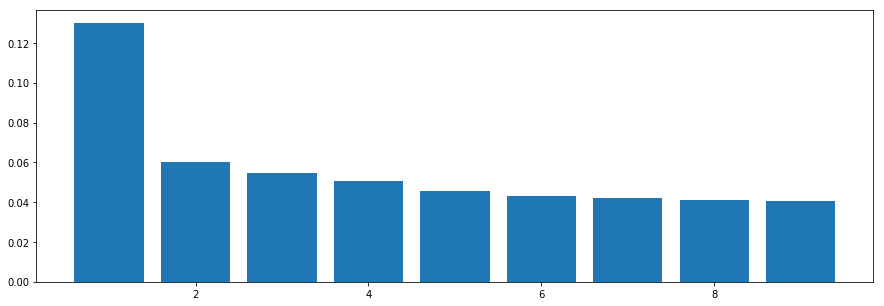

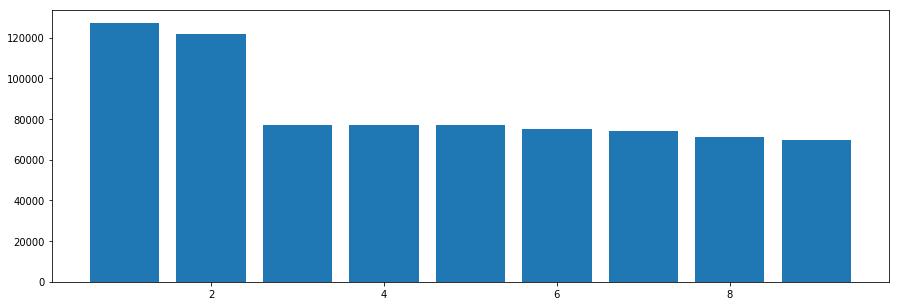

In [184]:
plt.figure(figsize=(15, 5))
plt.bar(n_feats, log_scores)
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(n_feats, norm_scores)
plt.show()

It seems that using sqft_living and the mean_log_price_zipcode features returned the best results. Let's try adjusting the hyperparameters (regularization) to see if we can fine tune the model.

In [97]:
# take grade out of X
X = X[:, [3, 8]]

In [98]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[0.1, 0.5, 1, 2, 10]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 2}
-0.05831945759466741


In [131]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[2, 3, 4, 5, 6, 7]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 5}
-0.05361417239513009


It seems like an alpha of 3 will work well. The score did not change much, but a higher alpha level will reduce the chances of overfitting

Now I will check that the errors are normally distributed and that there is no heteroskedascicity (change in variance of errors). I will also convert the log-scaled price back to regular dollars.

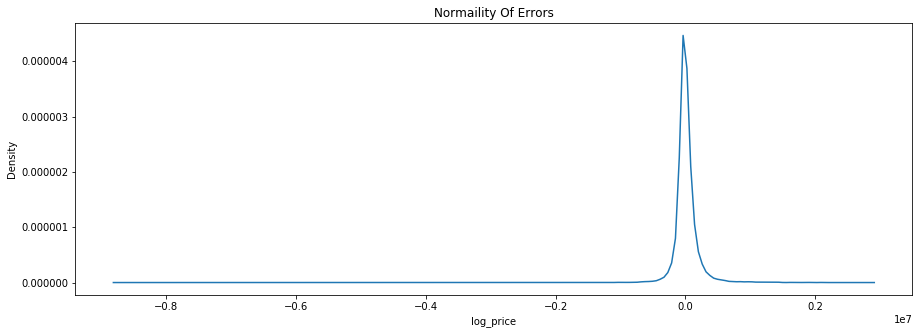

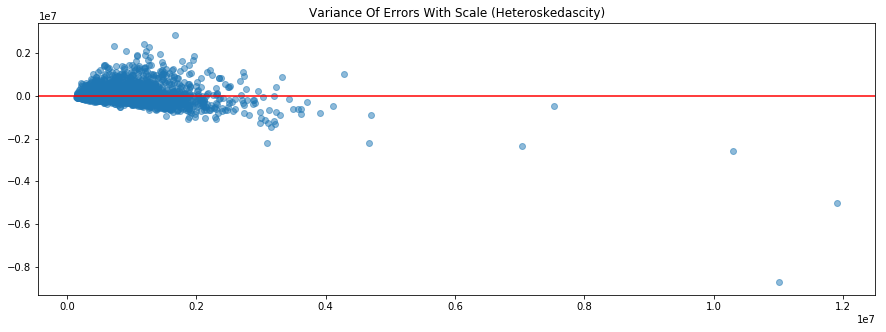

In [132]:
ridge = gs.best_estimator_

# take exp to convert back to dollars
y = np.exp(y)
y_hat = np.exp(ridge.predict(X))

errors = y - y_hat

# plot for normality
plt.figure(figsize=(15, 5))
sns.kdeplot(errors)
plt.title("Normaility Of Errors")
plt.show()

# plot for heteroskedascity
plt.figure(figsize=(15, 5))
plt.scatter(y_hat, errors, alpha=0.5)
plt.axhline(errors.mean(), color="red")
plt.title("Variance Of Errors With Scale (Heteroskedascity)")
plt.show()

It seems the model holds up well until the price gets extremely large.

## Interpreting Results

Now it is time to interpret the model. First let's take a look at the R-squared

In [126]:
r2_score(y, y_hat)

0.550873494324907

The R-squared value indicates that the log of the price is approximately %55 related to the mean zipcode log price and the sqft living space. In other words atleast %45 is not predictable with this model and these features. Next let's look at the accuracy of the model with root mean squared error and absolute mean error.

In [ ]:
# find rmse

The second thing to look at is the coefficients. These are hard to interpret on their own as they are relative to the feature. I will show an example of how much a standard deviation of added living space might do to a houses price.

In [117]:
# print coefficients
if "grade" in feats:
    feats.remove(grade)
print(dict(zip(feats, ridge.coef_)))

{'sqft_living': 0.2806003810230018, 'mean_log_price_zip': 0.30435783356493906}


In [118]:
# print the standard deviation for living space
df["sqft_living"].std()

916.6734426806632

In [119]:
# print mean house price
y.mean()

13.049380082470044

So if the living area of a house was increased by 916 sqft and the house was at average price in the beggining. The increase in price could look something like this.

In [121]:
np.exp(1*ridge.coef_[0]+y.mean()) - np.exp(y.mean())

150562.7259753205

According to the model there would be a $ 150,500 increase in price.